# 📌 Імпорт необхідних бібліотек

Для виконання аналізу даних, їхньої обробки, візуалізації та побудови моделей машинного навчання імпортовано такі бібліотеки:

### 🔹 Обробка даних:
- *StringIO* – для роботи з текстовими даними у вигляді файлового потоку.
- *NumPy* – для ефективної роботи з багатовимірними масивами та обчислювальними операціями.
- *pandas* – для завантаження, обробки та аналізу табличних даних.

### 🔹 Візуалізація:
- *Matplotlib* – для побудови графіків та діаграм.
- *Seaborn* – для статистичної візуалізації даних.

### 🔹 Методи машинного навчання:
- *scikit-learn*:
  - *RandomForestClassifier* – для побудови моделі класифікації на основі випадкового лісу.
  - *train_test_split* – для розділення вибірки на навчальну та тестову.
  - *LabelEncoder* – для кодування категоріальних змінних.
  - Метрики *accuracy_score*, *precision_score*, *recall_score*, *f1_score*, *roc_auc_score* – для оцінювання точності моделі.

### 🔹 Парсинг веб-даних:
- *requests* – для отримання HTML-сторінок із веб-сайтів.
- *BeautifulSoup* – для обробки HTML-коду та вилучення необхідної інформації.

### 🔹 Вимкнення системних попереджень:
- Щоб уникнути відображення зайвих попереджувальних повідомлень у процесі виконання коду, використано модуль *warnings*.


In [1]:
from io import StringIO  

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import requests
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# 🔍 Отримання даних із сайту  

Здійснюється підключення до веб-ресурсу та обробка отриманої інформації за допомогою *BeautifulSoup*.  


In [2]:
url = "https://data-analys.netlify.app/"
response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")

data_dict = {
    block.find("h5", class_="card-title").get_text(strip=True): 
    block.find("p", class_="card-text").get_text(strip=True)
    for block in soup.find_all("div", class_="card mb-3")[-2:]
}

print(data_dict.keys())

dict_keys(['Activity', 'Active users'])


# 📊 Підготовка та обробка даних  

Завантаження, об'єднання та очищення датасетів для подальшого аналізу. 

In [3]:
df_Active_users = pd.read_csv(StringIO(data_dict['Active users']))
df_Activity = pd.read_csv(StringIO(data_dict['Activity']))

df = df_Activity.merge(df_Active_users, how='left', on='user_id')

df['language'] = df['language'].replace('ru', 'eu')
df['activity_date'] = pd.to_datetime(df['activity_date'])
df = df.drop(df[df['total_seconds'] > df['total_seconds'].quantile(0.90)].index, axis=0).reset_index(drop=True)

print(df.info())
print(df.isna().sum())
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39611 entries, 0 to 39610
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   user_id                 39611 non-null  object        
 1   activity_date           39611 non-null  datetime64[ns]
 2   game_activity_name      39611 non-null  object        
 3   total_seconds           39611 non-null  int64         
 4   game_name               39611 non-null  object        
 5   language                39611 non-null  object        
 6   has_older_device_model  39611 non-null  bool          
 7   age                     39611 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(2), object(4)
memory usage: 2.2+ MB
None
user_id                   0
activity_date             0
game_activity_name        0
total_seconds             0
game_name                 0
language                  0
has_older_device_model    0
age          

,user_id,activity_date,game_activity_name,total_seconds,game_name,language,has_older_device_model,age
0,5Xx7q8xw22flTcYbZ1XZVQ==,2022-09-25,game 3: Main campaign,266,game 3,uk,False,26
1,5Xx7q8xw22flTcYbZ1XZVQ==,2022-09-25,game 3: Special events,43,game 3,uk,False,26
2,C/7YatYfa4qFbB1omZ7Jjw==,2022-09-05,game 2: Battle pass challenges,51,game 2,uk,False,52
3,C/7YatYfa4qFbB1omZ7Jjw==,2022-09-28,game 2: Battle pass challenges,846,game 2,uk,False,52
4,C/7YatYfa4qFbB1omZ7Jjw==,2022-10-13,game 2: Battle pass challenges,656,game 2,uk,False,52


In [4]:
df['activity_date'].dt.to_period('M').unique()

<PeriodArray>
['2022-09', '2022-10', '2022-11', '2022-12', '2022-08', '2022-07', '2022-03',
 '2022-04', '2022-06', '2022-05']
Length: 10, dtype: period[M]

# 📌 Аналіз розподілу мов користувачів  

Візуалізація кількості користувачів за мовними категоріями.  

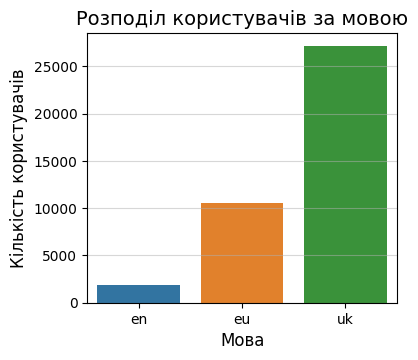

In [5]:
language = df.groupby('language')['user_id'].count()

plt.figure(figsize=(4, 3.5))
sns.barplot(x=language.index, y=language, hue=language.index)
plt.xlabel("Мова", fontsize=12)
plt.ylabel("Кількість користувачів", fontsize=12)
plt.title("Розподіл користувачів за мовою", fontsize=14)
plt.grid(axis="y", linestyle="-", alpha=0.5)

plt.show()

# 📌 Аналіз використання застарілих пристроїв  

Діаграма відображає розподіл користувачів залежно від наявності застарілої моделі пристрою.  

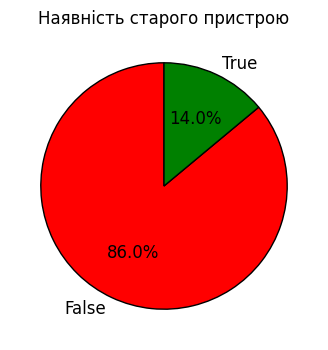

In [6]:
has_older_device = df.groupby('has_older_device_model')['user_id'].count().reset_index()

plt.figure(figsize=(4, 4))

plt.pie(
    has_older_device['user_id'], 
    labels=has_older_device['has_older_device_model'], 
    colors=["red", "green"], 
    startangle=90, 
    textprops={"fontsize": 12}, 
    wedgeprops={"linewidth": 1, "edgecolor": "black"}, 
    autopct="%1.1f%%"
)

plt.title('Наявність старого пристрою')
plt.show()


# 📊 Динаміка активності користувачів  

### Основні метрики:  
- **DAU (Daily Active Users)** – кількість унікальних користувачів, які заходили в систему протягом дня.  
- **WAU (Weekly Active Users)** – кількість унікальних користувачів за тиждень, що допомагає оцінити стабільність залученості.  
- **MAU (Monthly Active Users)** – кількість унікальних користувачів за місяць, що дозволяє аналізувати довготривалу активність.


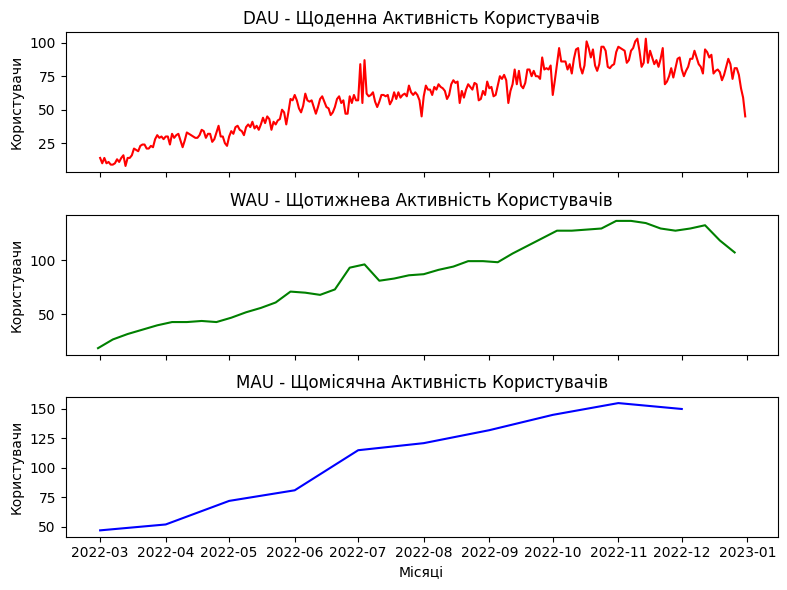

In [7]:
dau = df.groupby('activity_date')['user_id'].nunique().reset_index()

df['week_start_date'] = df['activity_date'].dt.to_period('W').apply(lambda x: x.start_time)
wau = df.groupby('week_start_date')['user_id'].nunique().reset_index()

df['month_start_date'] = df['activity_date'].dt.to_period('M').apply(lambda x: x.start_time)
mau = df.groupby('month_start_date')['user_id'].nunique().reset_index()

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

sns.lineplot(ax=axes[0], x=dau["activity_date"], y=dau['user_id'], color="red")
axes[0].set_title("DAU - Щоденна Активність Користувачів")
axes[0].set_ylabel("Користувачи")

sns.lineplot(ax=axes[1], x=wau["week_start_date"], y=wau['user_id'], color="green")
axes[1].set_title("WAU - Щотижнева Активність Користувачів")
axes[1].set_ylabel("Користувачи")

sns.lineplot(ax=axes[2], x=mau["month_start_date"], y=mau["user_id"], color="blue")
axes[2].set_title("MAU - Щомісячна Активність Користувачів")
axes[2].set_ylabel("Користувачи")
axes[2].set_xlabel("Місяці")

plt.tight_layout()
plt.show()

# 📉 Відношення Average DAU до WAU  

### Що аналізується?  

- **Середній DAU за тиждень** – Середня кількість щоденно активних користувачів за тиждень:  
$$ \text{Average DAU} = \frac{\sum_{i=1}^{7} DAU_i}{7} $$
- **Average DAU/WAU** – показник, що дозволяє оцінити, наскільки часто користувачі взаємодіють із системою протягом тижня. 



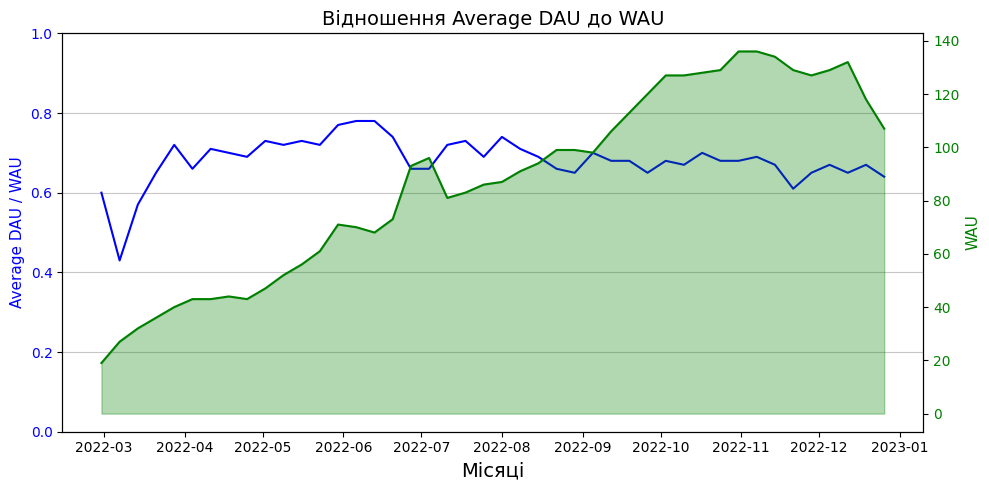

In [8]:
dau['week_start_date'] = dau['activity_date'].dt.to_period('W').apply(lambda x: x.start_time)
average_dau = dau.groupby('week_start_date')['user_id'].mean().reset_index().round(2)

dau_to_wau = (average_dau['user_id'] / wau['user_id']).round(2)

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Місяці', fontsize=14)
ax1.set_ylabel('Average DAU / WAU', color='blue', fontsize=11)
ax1.plot(average_dau['week_start_date'], dau_to_wau, color='blue', label='DAU / WAU')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, 1)
ax1.yaxis.grid(True, linestyle='-', alpha=0.7)

ax2 = ax1.twinx()
ax2.set_ylabel('WAU', color='green', fontsize=11)
ax2.fill_between(wau['week_start_date'], wau['user_id'], color='green', alpha=0.3)
ax2.plot(wau['week_start_date'], wau['user_id'], color='green', label='WAU')
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_title("Відношення Average DAU до WAU", fontsize=14)

fig.tight_layout()
plt.show()

# 🔥 Когортний аналіз користувачів  

### Основні метрики:  
- **Кількість користувачів у кожній когорті** (теплова карта в зелених відтінках).  
- **Процент утримання користувачів** у наступні місяці після першої активності (теплова карта в синіх відтінках).  

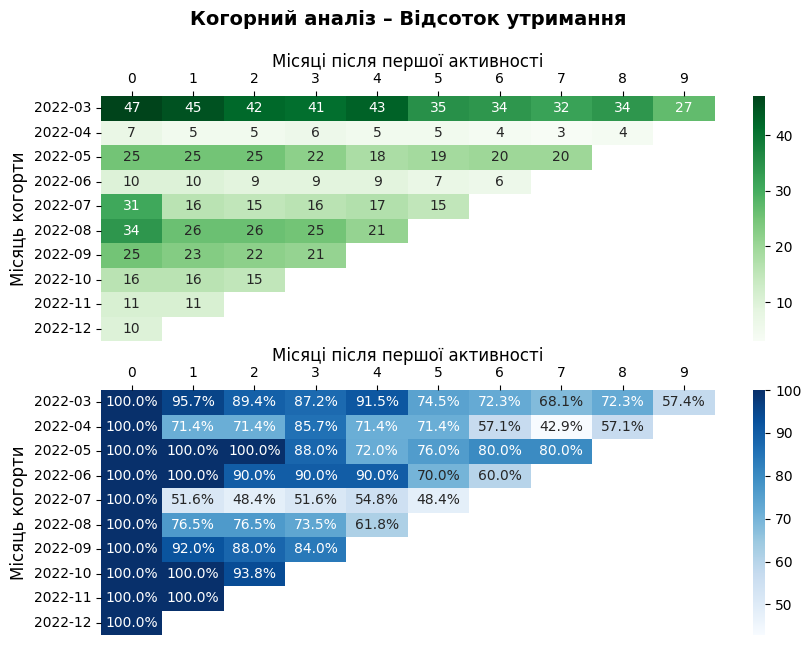

In [9]:
df['cohort_month'] = df.groupby('user_id')['activity_date'].transform('min').dt.to_period('M')
df["activity_month"] = df["activity_date"].dt.to_period("M")
df["cohort_index"] = (df["activity_month"] - df["cohort_month"]).apply(lambda x: x.n)

cohort_table = df.groupby(["cohort_month", "cohort_index"])["user_id"].nunique().unstack().fillna(0)

fig, axes = plt.subplots(2, 1, figsize=(7*np.sqrt(2), 7), gridspec_kw={'wspace': 0.3})

ax1 = sns.heatmap(cohort_table, annot=True, cmap="Greens", mask=cohort_table == 0, ax=axes[0])
ax1.set_title("Когорний аналіз – Відсоток утримання", pad=20, fontsize=14, fontweight="bold")
ax1.set_xlabel("Місяці після першої активності", fontsize=12)
ax1.set_ylabel("Місяць когорти", fontsize=12)
ax1.xaxis.set_label_position("top")  
ax1.xaxis.tick_top()

cohort_size = cohort_table.iloc[:, 0] 
retention_matrix = cohort_table.div(cohort_size, axis=0) * 100 

annot = retention_matrix.applymap(lambda x: f"{x:.1f}%" if x > 0 else "")

ax2 = sns.heatmap(retention_matrix, annot=annot, fmt="", cmap="Blues", mask=retention_matrix == 0, ax=axes[1])
ax2.set_xlabel("Місяці після першої активності", fontsize=12)
ax2.set_ylabel("Місяць когорти", fontsize=12)
ax2.xaxis.set_label_position("top")  
ax2.xaxis.tick_top()

plt.show()


## Визначення ключових факторів відтоку користувачів  

Ця модель **не просто передбачає відтік**, а **визначає, які фактори найбільше на нього впливають**.  


1. **Формуються ознаки** (*features*), що можуть впливати на відтік:  
   - Вік  
   - Мова  
   - Наявність старого пристрою  
   - Різноманітність активності  
   - Кількість днів активності в грі  
   - Чи активно гравець протягом першого тижня  

2. **Навчається модель** (*Random Forest Classifier*), яка прогнозує ймовірність відтоку.  

3. Визначається важливість факторів, щоб зрозуміти, **які змінні найбільше впливають на відтік**.  



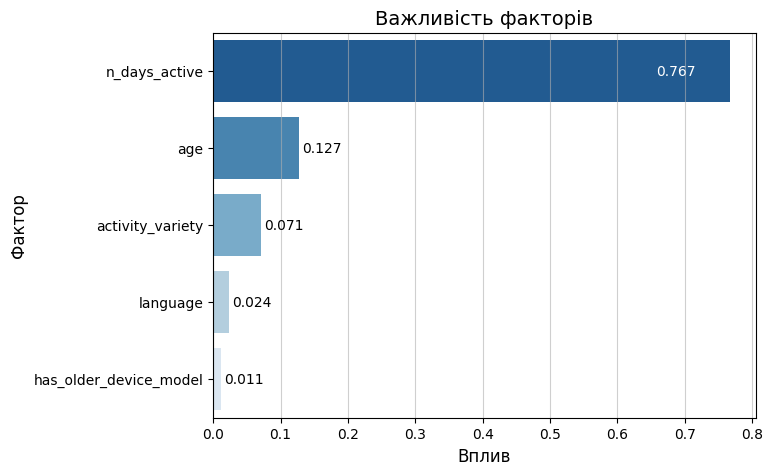

Accuracy: 0.8573
Precision: 0.7244
Recall: 0.4969
F1-score: 0.5895
ROC-AUC: 0.9146
Threshold: 0.40 | Precision: 0.6221 | Recall: 0.6499 | F1-score: 0.6357
Threshold: 0.45 | Precision: 0.6553 | Recall: 0.5887 | F1-score: 0.6202
Threshold: 0.50 | Precision: 0.7244 | Recall: 0.4969 | F1-score: 0.5895
Threshold: 0.55 | Precision: 0.8052 | Recall: 0.3819 | F1-score: 0.5181
Threshold: 0.60 | Precision: 0.8540 | Recall: 0.3329 | F1-score: 0.4791
Threshold: 0.65 | Precision: 0.8951 | Recall: 0.2821 | F1-score: 0.4290


In [10]:
df['n_days_active'] = df.groupby('user_id')['activity_date'].transform('nunique')
df['activity_variety'] = df.groupby('user_id')['game_activity_name'].transform('nunique')
df['churn'] = ((df['cohort_index'] <= 1) & (df['n_days_active'] < df['n_days_active'].median())).astype(int)

df['language'] = LabelEncoder().fit_transform(df['language'])
df['has_older_device_model'] = df['has_older_device_model'].astype(int)

features = ['age', 'language', 'has_older_device_model', 'activity_variety', 'n_days_active']
X = df[features]
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_proba = rf.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

feature_importance = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(7, 5))
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette="Blues_r")

for index, value in enumerate(feature_importance.values):
    if value > 0.7:
        plt.text(value - 0.11, index, f"{value:.3f}", va='center', fontsize=10, color='white')
    else: 
        plt.text(value + 0.005, index, f"{value:.3f}", va='center', fontsize=10)

plt.title('Важливість факторів', fontsize=14)
plt.xlabel('Вплив', fontsize=12)
plt.ylabel('Фактор', fontsize=12)
plt.grid(axis="x", linestyle="-", alpha=0.6)
plt.show()

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

def evaluate_threshold(threshold):
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    precision = precision_score(y_test, y_pred_threshold)
    recall = recall_score(y_test, y_pred_threshold)
    f1 = f1_score(y_test, y_pred_threshold)
    print(f"Threshold: {threshold:.2f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1-score: {f1:.4f}")

for t in np.arange(0.4, 0.7, 0.05):
    evaluate_threshold(t)

### 📊 Аналіз результатів моделі

#### **Основні метрики класифікації**  
- **Accuracy**: 0.8573 – загальна точність моделі у передбаченні відтоку користувачів.  
- **Precision**: 0.7244 – точність моделі у визначенні тих, хто реально залишив гру.  
- **Recall**: 0.4969 – частка користувачів, які фактично пішли, і були правильно визначені.  
- **F1-score**: 0.5895 – баланс між точністю та повнотою, що показує ефективність моделі.  
- **ROC-AUC**: 0.9146 – якість розділення користувачів на тих, хто залишиться та піде.   

#### ⚖️ **Вибір порогу класифікації**

Я обрав **Threshold = 0.50**, оскільки він дає **збалансоване співвідношення** між **Precision (72.44%)** і **Recall (49.69%)**.  

#### **🔎 Висновок**  
Окрім очевидного впливу активності, **вік гравця відіграє значну роль**. Це означає, що певні вікові групи схильні до більшого або меншого відтоку, і варто адаптувати ігровий контент чи комунікацію відповідно.  

Водночас **мова та модель пристрою практично не впливають** на відтік користувачів. Це свідчить про те, що технічні обмеження чи мовні фактори не є ключовими бар'єрами для утримання аудиторії.  